In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


import pyro
from svgsa.pathway_dispersion import select_highest_variance_gs
from sklearn.preprocessing import scale
from svgsa.VAE import VAE
from svgsa.Interface import fit_SVGSA
import torch
import pandas as pd
from tqdm import trange

from matplotlib.pyplot import rc_context


In [2]:
plt.style.use('ggplot')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [4]:
adata =  sc.datasets.pbmc68k_reduced()

In [5]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [6]:
adata.obsm["raw"] = adata.raw.X.toarray().astype(np.float32)

In [7]:
filter_genes = 100
idx_to_filt = np.sum(adata.X > 0, axis = 0) > filter_genes
adata = adata[:,idx_to_filt]
adata.obsm["raw"] = adata.obsm["raw"][:,idx_to_filt]

In [8]:
adata.X

array([[-0.326, -0.728, -0.301, ...,  0.519, -0.636,  4.011],
       [ 1.171,  0.795, -1.2  , ...,  1.172,  2.63 , -0.49 ],
       [-0.326,  0.483, -1.2  , ...,  0.722,  0.663, -0.49 ],
       ...,
       [-0.326, -0.728, -1.2  , ...,  0.152, -0.636,  1.226],
       [-0.326, -0.728, -0.386, ..., -0.326, -0.636, -0.49 ],
       [-0.326,  0.148,  0.762, ...,  0.239, -0.636, -0.49 ]],
      dtype=float32)

In [9]:
### Loop the data lines
with open("data/cell_markers.txt", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

column_names = [i for i in range(0, max(col_count))]


gsts = pd.read_csv("data/cell_markers.txt",header=None, delimiter="\t", names=column_names,low_memory=False)

In [10]:
gsts = gsts.transpose()
gsts.columns = gsts.iloc[0]
gsts = gsts[2:]

In [11]:
gsts_dict = gsts.apply(lambda x: [x.dropna()]).to_dict("list")


In [12]:
gsts_dict["FAN_EMBRYONIC_CTX_EX_1_EXCITATORY_NEURON"]

[2         ENC1
 3       PANTR1
 4    LINC01102
 5        MEIS2
 6          SLA
 7        CSRP2
 8        EIF1B
 Name: FAN_EMBRYONIC_CTX_EX_1_EXCITATORY_NEURON, dtype: object]

In [13]:
import progeny

n_genes = 100

model = progeny.load_model(
        organism='Human',
        top=n_genes # Number of top significant target genes per pathway to use
    )

model

pathway,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
gene,,,,,,,,,,,,,,
ABCA12,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,9.597182
ABCA6,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-3.271537,0.0,0.000000,0.0,0.0,0.000000
ABCA8,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-1.709245,0.0,0.000000,0.0,0.0,0.000000
ABCC4,9.374285,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ABCC5,0.000000,0.000000,-4.854988,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNFX1,0.000000,0.000000,0.000000,0.0,6.496398,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ZNRF4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.033885,0.0,0.0,0.000000
ZSCAN2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-3.158743,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [14]:
gsts = model
#gsts.columns = gsts.iloc[0]
#gsts = gsts[2:]
gsts

pathway,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
gene,,,,,,,,,,,,,,
ABCA12,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,9.597182
ABCA6,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-3.271537,0.0,0.000000,0.0,0.0,0.000000
ABCA8,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-1.709245,0.0,0.000000,0.0,0.0,0.000000
ABCC4,9.374285,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ABCC5,0.000000,0.000000,-4.854988,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNFX1,0.000000,0.000000,0.000000,0.0,6.496398,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
ZNRF4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.033885,0.0,0.0,0.000000
ZSCAN2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-3.158743,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [15]:
gsts_dict = gsts.apply(lambda x: gsts.index[np.abs(x) > 0.].tolist()).to_dict("list")

In [16]:
pyro.enable_validation()
#torch.autograd.set_detect_anomaly(True)

adata_new, model, loss, N_GS_list = fit_SVGSA(adata, gsts_dict, z_dim_gs=2, z_dim_uns=2,
                                   
                                   num_iafs =0, batch_size=100, epochs=250, 
                                   
                                   N_GS=10, normalize = False,lr = 0.001, CUDA = True, iaf_dim=50, fixed = False)   #batch_size=1024

['Androgen' 'EGFR' 'Estrogen' 'Hypoxia' 'JAK-STAT' 'MAPK' 'NFkB' 'PI3K'
 'TGFb' 'TNFa']


Epoch loss 46672716.878151: 100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


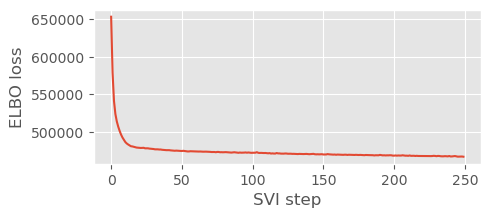

In [17]:
plt.figure(figsize=(5, 2))
plt.plot(loss)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

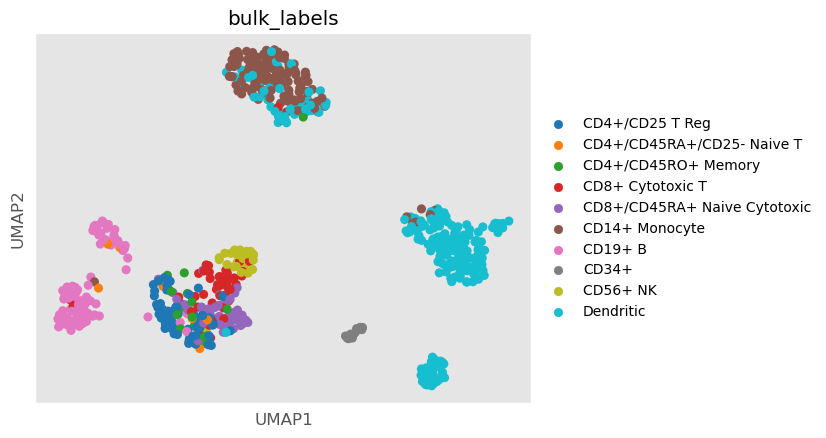

In [18]:
sc.pl.umap(adata, color = "bulk_labels")

In [19]:
print( adata_new.obsm["X_svgsa_gs"].shape )
adata_new.obsm["X_svgsa_gs"]

torch.Size([700, 2])


tensor([[ 0.0376, -0.2608],
        [-1.1499, -0.0747],
        [ 0.3316, -0.1427],
        ...,
        [-0.2535,  0.0167],
        [ 0.3316, -0.1427],
        [ 0.3423, -0.2655]], device='cpu')

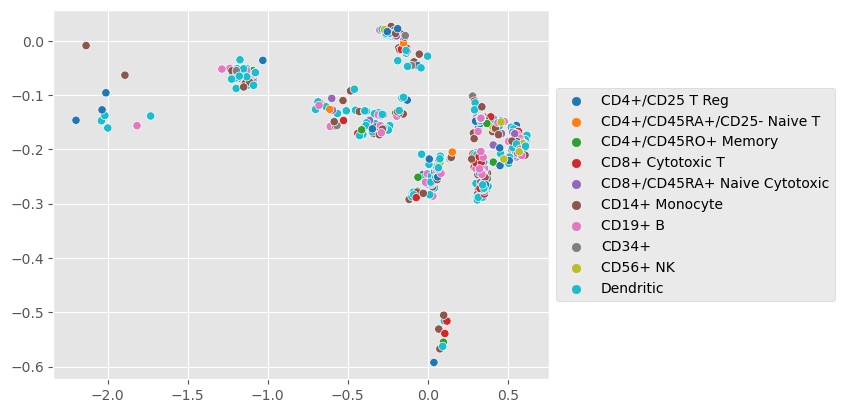

In [20]:
import seaborn as sns

sns.scatterplot(x = adata_new.obsm["X_svgsa_gs"][:,0], y = adata_new.obsm["X_svgsa_gs"][:,1], hue = adata_new.obs.bulk_labels, palette="tab10") 
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

In [21]:
sc.pp.neighbors(adata_new, use_rep="X_svgsa_gs")
sc.tl.umap(adata_new, n_components=2)

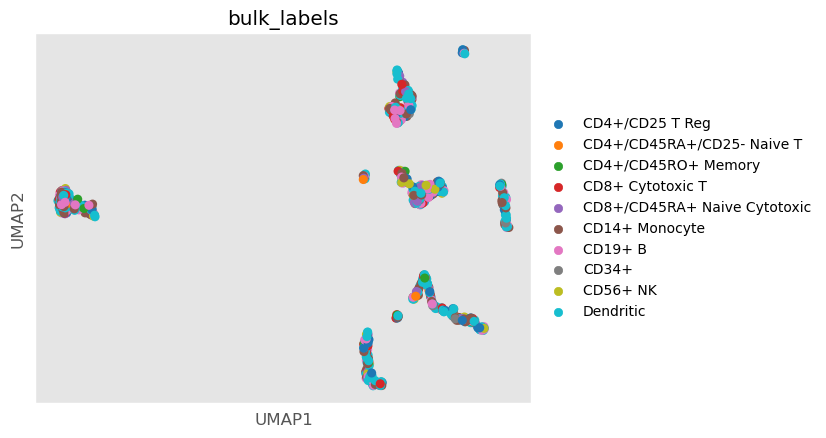

In [22]:
sc.pl.umap(adata_new, color = "bulk_labels")

In [23]:
adata

AnnData object with n_obs × n_vars = 700 × 575
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB', 'PI3K', 'TGFb', 'TNFa'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw', 'X_svgsa', 'X_reconstructed', 'X_svgsa_gs', 'X_svgsa_uns'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

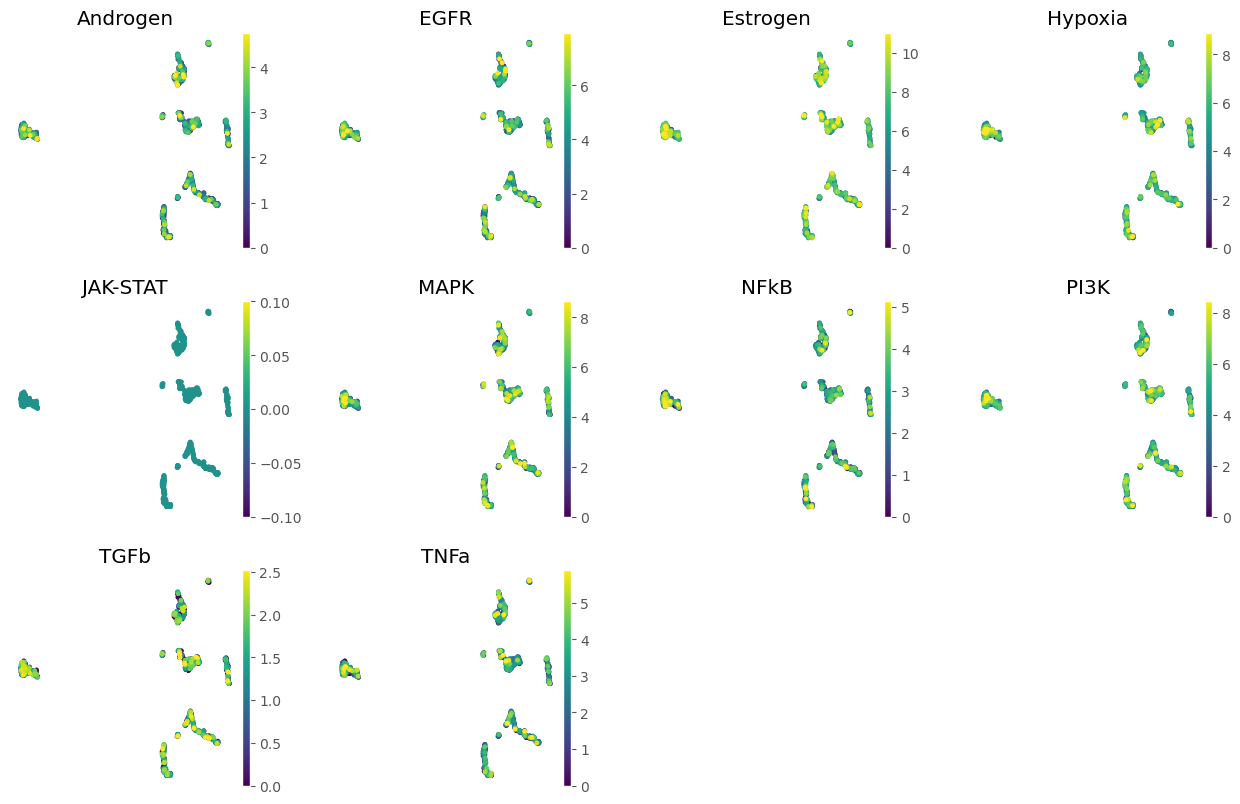

In [24]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(adata_new, color=["Androgen","EGFR", 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB', 'PI3K', 'TGFb', 'TNFa'], s=50, frameon=False, ncols=4, vmax='p99')

In [25]:
print( adata_new.obsm["X_svgsa_uns"].shape )
adata_new.obsm["X_svgsa_uns"]

torch.Size([700, 2])


tensor([[-0.1744, -3.5905],
        [-1.5559, -4.3760],
        [-3.9782,  2.1812],
        ...,
        [-0.3385,  1.1420],
        [ 3.4986,  1.9621],
        [ 4.2406, -2.6909]], device='cpu')

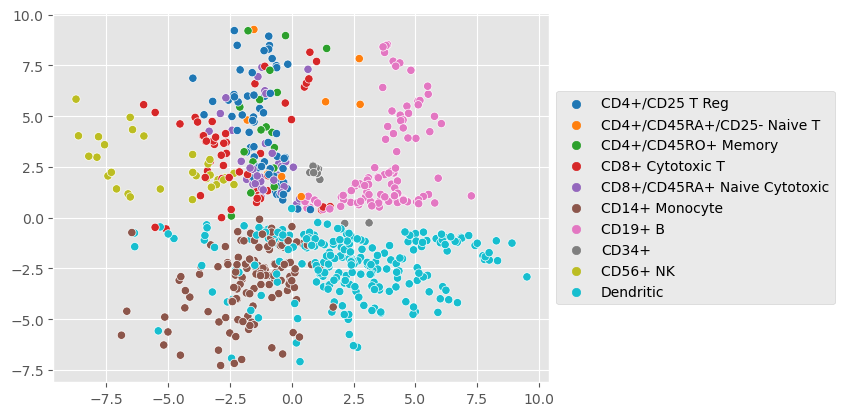

In [26]:
sns.scatterplot(x = adata_new.obsm["X_svgsa_uns"][:,0], y = adata_new.obsm["X_svgsa_uns"][:,1], hue = adata_new.obs.bulk_labels, palette="tab10") 
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

In [27]:
sc.pp.neighbors(adata_new, use_rep="X_svgsa_uns")
sc.tl.umap(adata_new, n_components=2)

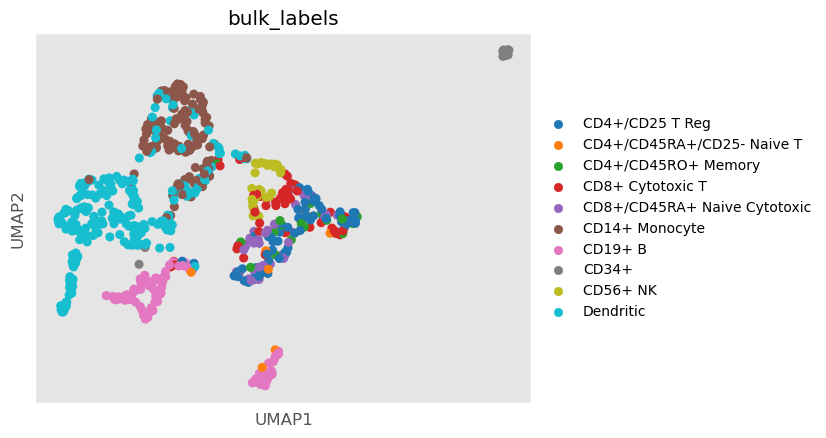

In [28]:
sc.pl.umap(adata_new, color = "bulk_labels")

In [29]:
sc.pp.neighbors(adata_new, use_rep="X_svgsa")
sc.tl.umap(adata_new, n_components=4)

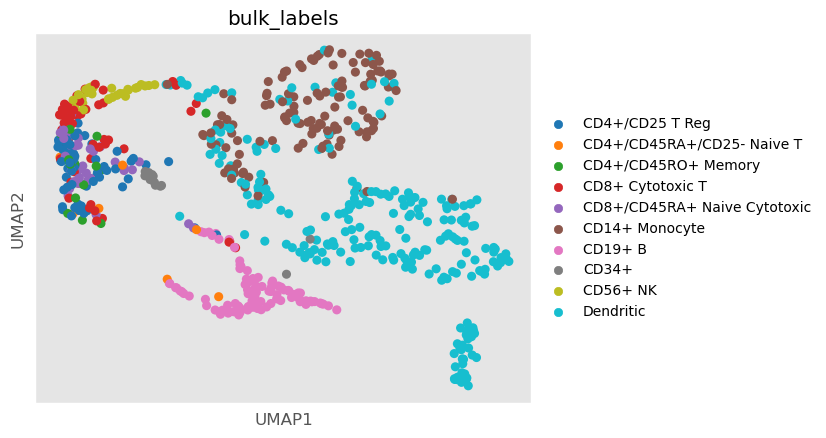

In [30]:
sc.pl.umap(adata_new, color = "bulk_labels")

In [31]:
print(adata_new.obsm["X_reconstructed"])

[[ 0.92903732  0.66368513  1.35522461 ...  1.98232403  0.28437663
   0.41562451]
 [ 1.16760746  0.82363999  1.10340703 ...  2.10986175  0.47257231
   0.24165445]
 [-0.01173857  0.7123617   1.1519229  ...  2.25664345  0.93717125
   0.31379146]
 ...
 [ 0.04340406  1.08441795  0.98854584 ...  0.83832511  0.54313889
   0.65194965]
 [ 0.04341747  0.8197223   1.46231491 ...  0.73920608  0.17180505
   0.27755683]
 [ 0.03678034  0.80895674  1.57583584 ...  1.70426292  0.76681822
   0.294069  ]]


In [32]:
torch.tensor(adata.X)

tensor([[-0.3260, -0.7280, -0.3010,  ...,  0.5190, -0.6360,  4.0110],
        [ 1.1710,  0.7950, -1.2000,  ...,  1.1720,  2.6300, -0.4900],
        [-0.3260,  0.4830, -1.2000,  ...,  0.7220,  0.6630, -0.4900],
        ...,
        [-0.3260, -0.7280, -1.2000,  ...,  0.1520, -0.6360,  1.2260],
        [-0.3260, -0.7280, -0.3860,  ..., -0.3260, -0.6360, -0.4900],
        [-0.3260,  0.1480,  0.7620,  ...,  0.2390, -0.6360, -0.4900]],
       dtype=torch.float32)

# Standard analysis

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

NotImplementedError: No view type has been registered for <class 'torch.Tensor'>

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


c:\Users\Lorzo\miniconda3\envs\thesis_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\Lorzo\miniconda3\envs\thesis_env\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


In [ ]:
sc.pp.scale(adata, max_value=10)


In [ ]:
sc.tl.pca(adata, svd_solver='arpack')


In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [ ]:
sc.tl.umap(adata)


In [ ]:
sc.tl.leiden(adata)


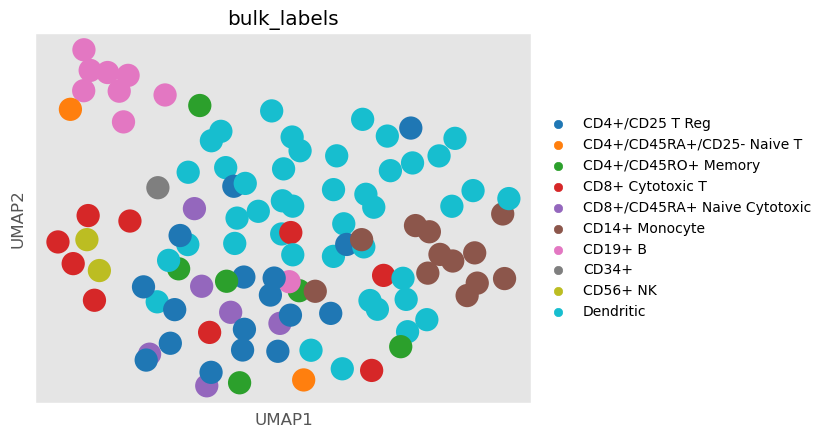

In [ ]:
sc.pl.umap(adata,  color = "bulk_labels")